# Requierments

In [20]:
import torch

print("Pytorch version:", torch.__version__)
!python -V

Pytorch version: 2.2.2
Python 3.11.0


# Preparing the Data

In [1]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('\nLen of letters:', n_letters, '\nNum of categories:', n_categories, "\n", "Categories:", all_categories, "\n", "Category lines:", category_lines)
print(unicodeToAscii("O'Néàl"))


Len of letters: 59 
Num of categories: 18 
 Categories: ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish'] 
 Category lines: {'Czech': ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky', 'Blecha', 'Bleskan', 'Blober', 'Bock', 'Bohac', 'Bohunovsky', 'Bolcar', 'Borovka', 'Borovski', 'Borowski', 'Borovsky', 'Brabbery', 'Brezovjak', 'Brousil', 'Bruckner', 'Buchta', 'Cablikova', 'Camfrlova', 'Cap', 'Cerda', 'Cermak', 'Chermak', 'Cermak', 'Cernochova', 'Cernohous', 'Cerny', 'Cerney', 'Cerny', 'Cerv', 'Cervenka', 'Chalupka', 'Charlott', 'Chemlik', 'Chicken', 'Chilar', 'Chromy', 'Cihak', 'Clineburg', 'Klineberg', 'Cober', 'Colling', 'Cvacek', 'Czabal', 'Damell', 'Demall', 'Dehmel', 'Dan

# Creating the Network

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
rnn = RNN(n_letters, 128, n_letters)
rnn

RNN(
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

## Preparing for Training

In [4]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    # print("category, line: ", category, line)
    category_tensor = categoryTensor(category)
    # print("category_tensor: ", category_tensor)
    input_line_tensor = inputTensor(line)
    # print("input_line_tensor: ", input_line_tensor)
    target_line_tensor = targetTensor(line)
    # print("target_line_tensor: ", target_line_tensor)
    return category_tensor, input_line_tensor, target_line_tensor

In [7]:
category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()

In [8]:
target_line_tensor.unsqueeze_(-1)

tensor([[20],
        [13],
        [ 2],
        [ 0],
        [13],
        [58]])

In [9]:
hidden = rnn.initHidden()
rnn(category_tensor, input_line_tensor[0], hidden)

(tensor([[-4.0574, -4.1647, -4.0604, -4.0880, -4.0831, -4.0399, -4.0646, -4.0811,
          -4.1454, -3.9474, -4.0856, -4.1366, -4.1237, -4.0300, -4.0975, -3.9776,
          -3.9847, -4.1132, -4.0948, -4.0766, -4.0883, -4.0279, -4.0702, -4.0116,
          -4.1396, -4.0158, -4.0181, -4.2310, -4.1159, -4.0496, -4.0028, -4.0811,
          -4.0811, -4.0811, -4.0608, -4.0026, -4.1575, -4.1235, -4.1047, -4.1067,
          -4.1455, -4.0332, -4.1160, -4.1146, -4.0314, -4.0305, -4.0760, -4.0811,
          -4.0811, -4.1347, -4.0611, -4.0848, -3.9995, -4.1920, -4.1646, -4.0599,
          -4.0750, -4.0754, -4.0811]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[-0.0072,  0.0049,  0.1253, -0.0110,  0.0363, -0.0725, -0.0418, -0.0642,
           0.0274,  0.0130,  0.0993,  0.0257,  0.0114, -0.0538,  0.0216, -0.0295,
           0.0378, -0.0234,  0.0559,  0.0951,  0.0439, -0.1028,  0.1295, -0.0047,
          -0.0891,  0.0617,  0.0399,  0.0815, -0.0665, -0.0494, -0.0481,  0.1251,
          -0.1375, -0.0670,

## Training the Network

In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
n_iters = 100000
print_every = 5000
plot_every = 1000
all_losses = []

# Separate loss tracking for printing and plotting
print_loss_total = 0  # Reset every print_every iters
plot_loss_total = 0   # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
        # Average loss over the last print_every iterations
        avg_loss = print_loss_total / print_every
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, avg_loss))
        print_loss_total = 0

    if iter % plot_every == 0:
        # Average loss over the last plot_every iterations
        all_losses.append(plot_loss_total / plot_every)
        plot_loss_total = 0

0m 13s (5000 5%) 3.2002
0m 26s (10000 10%) 2.8572
0m 40s (15000 15%) 2.7341
0m 53s (20000 20%) 2.6441
1m 5s (25000 25%) 2.5829
1m 19s (30000 30%) 2.5437
1m 32s (35000 35%) 2.4921
1m 47s (40000 40%) 2.4660
2m 2s (45000 45%) 2.4545
2m 16s (50000 50%) 2.4272
2m 29s (55000 55%) 2.4093
2m 42s (60000 60%) 2.3973
2m 55s (65000 65%) 2.3641
3m 7s (70000 70%) 2.3693
3m 21s (75000 75%) 2.3678
3m 36s (80000 80%) 2.3413
3m 49s (85000 85%) 2.3330
4m 5s (90000 90%) 2.3351
4m 20s (95000 95%) 2.3058
4m 34s (100000 100%) 2.3152


## Plotting the Losses


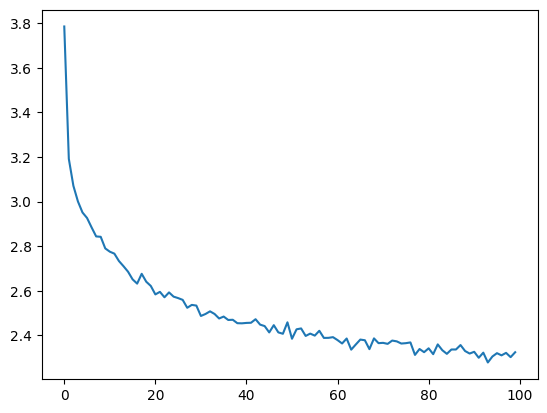

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

# Sampling the Network

In [14]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print("start_letter: ", start_letter)
        print(sample(category, start_letter))

In [15]:
samples('Russian', 'RUS')

start_letter:  R
Rovakov
start_letter:  U
Uanikov
start_letter:  S
Shinokov


In [16]:
samples('German', 'GER')

start_letter:  G
Gangereng
start_letter:  E
Erenger
start_letter:  R
Roner


In [17]:
samples('Spanish', 'SPA')

start_letter:  S
Sonella
start_letter:  P
Pane
start_letter:  A
Allan


In [18]:
samples('Chinese', 'CHI')

start_letter:  C
Chan
start_letter:  H
Han
start_letter:  I
Iun


In [19]:
samples('Arabic', 'Sal')

start_letter:  S
Sana
start_letter:  a
anas
start_letter:  l
lasha
